In [185]:
import numpy as np
import pandas as pd
import seaborn as sns
import sen_plots as sen

import geopandas as gpd

import shapely.wkt
import shapely.affinity

from matplotlib import pyplot as plt

In [5]:
# maceteador de aspect ratio
def aspect_ratio_locker(aspect_ratio, multiplier):
    return([i * multiplier for i in aspect_ratio])

<h1>Índice<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importa-o-mapa-das-favelas" data-toc-modified-id="Importa-o-mapa-das-favelas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importa o mapa das favelas</a></span></li><li><span><a href="#Importa-os-dados-das-escolas-(IDEB)" data-toc-modified-id="Importa-os-dados-das-escolas-(IDEB)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importa os dados das escolas (IDEB)</a></span><ul class="toc-item"><li><span><a href="#Refaz-todas-as-projeções-à-luz-da-projeção-do-mapa-das-favelas-(a-projeção-inicial-foi-tirada-do-shapefile-original-da-localização-das-escolas)" data-toc-modified-id="Refaz-todas-as-projeções-à-luz-da-projeção-do-mapa-das-favelas-(a-projeção-inicial-foi-tirada-do-shapefile-original-da-localização-das-escolas)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Refaz todas as projeções à luz da projeção do mapa das favelas (a projeção inicial foi tirada do shapefile original da localização das escolas)</a></span></li></ul></li><li><span><a href="#Favelas-expandidas" data-toc-modified-id="Favelas-expandidas-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Favelas expandidas</a></span></li><li><span><a href="#Verifica-as-diferenças-de-INSE-entre-escolas-que-ficam-dentro-e-fora-da-favela" data-toc-modified-id="Verifica-as-diferenças-de-INSE-entre-escolas-que-ficam-dentro-e-fora-da-favela-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Verifica as diferenças de INSE entre escolas que ficam dentro e fora da favela</a></span></li><li><span><a href="#Testa-o-efeito-dos-limites-de-favela-sobre-o-IDEB" data-toc-modified-id="Testa-o-efeito-dos-limites-de-favela-sobre-o-IDEB-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testa o efeito dos limites de favela sobre o IDEB</a></span></li><li><span><a href="#Olha-apenas-para-os-pares-fora-de-favela" data-toc-modified-id="Olha-apenas-para-os-pares-fora-de-favela-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Olha apenas para os pares fora de favela</a></span></li></ul></div>

# Importa o mapa das favelas

In [95]:
map_favelas = gpd.read_file("./shapefiles/Limite_Favelas/Limite_Favelas.shp", encoding = "latin1")

Uma das coisas importantes de pegar com o geopandas é a projeção inicial dos dados. A linha de código abaixo pega isso pra podermos lançar tanto as escolas quanto as favelas na mesma projeção. Vou usar a projeção nativa do mapa das favelas.

In [105]:
map_favelas.crs

{'init': 'epsg:31983'}

# Importa os dados das escolas (IDEB)

In [107]:
#importa os 3 datasets que eu quero comparar o INSE
ruim_pra_bom = pd.read_csv("referencias_ruim_bom.csv")
pessimo_pra_bom = pd.read_csv("referencias_pessimo_bom.csv")
risco = pd.read_csv("risco_map.csv")

## Refaz todas as projeções à luz da projeção do mapa das favelas (a projeção inicial foi tirada do shapefile original da localização das escolas)

In [108]:
risco = gpd.GeoDataFrame(risco, geometry=risco["geometry"].map(shapely.wkt.loads),
                             crs = {"init" : "epsg:29183"})

risco["geometry"] = risco.geometry.to_crs({'init' : 'epsg:31983'})

In [109]:
ruim_pra_bom = gpd.GeoDataFrame(ruim_pra_bom, geometry=ruim_pra_bom["geometry"].map(shapely.wkt.loads),
                             crs = {"init" : "epsg:29183"})

ruim_pra_bom["geometry"] = ruim_pra_bom.geometry.to_crs({'init' : 'epsg:31983'})

In [110]:
pessimo_pra_bom = gpd.GeoDataFrame(pessimo_pra_bom, geometry=pessimo_pra_bom["geometry"].map(shapely.wkt.loads),
                             crs = {"init" : "epsg:29183"})

pessimo_pra_bom["geometry"] = pessimo_pra_bom.geometry.to_crs({'init' : 'epsg:31983'})

In [120]:
map_geral_rio = gpd.read_file("./shapefiles/Limite_Bairro/Limite_Bairro.shp", encoding = "latin1")

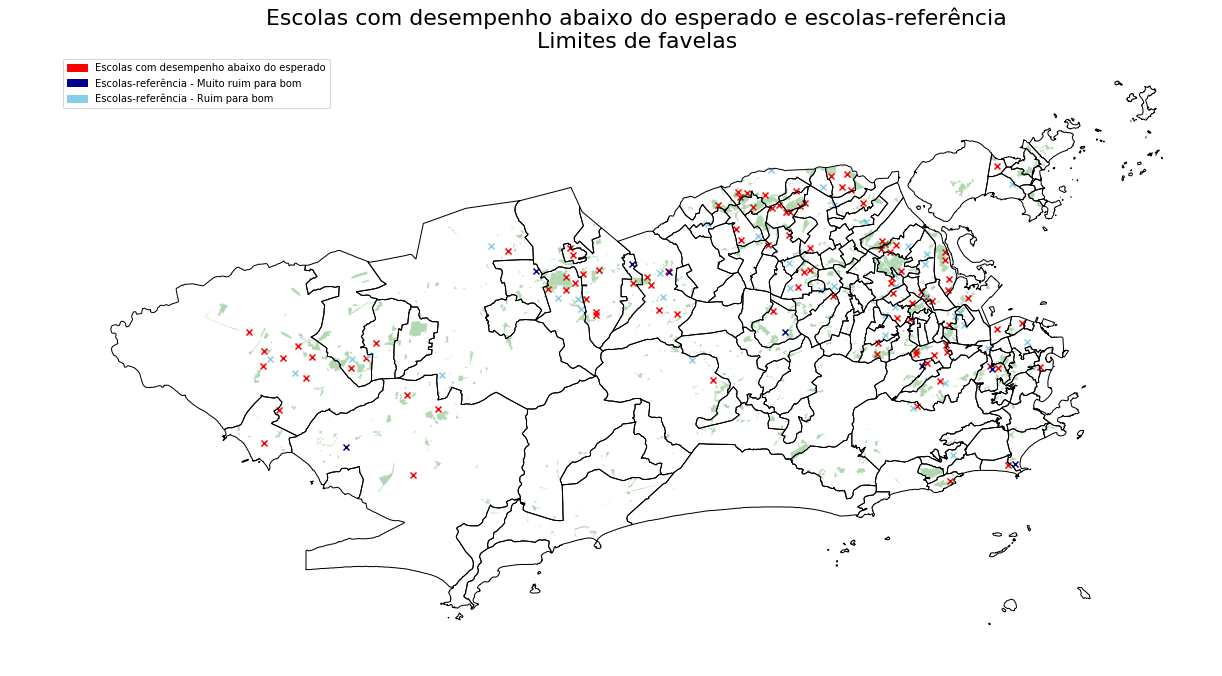

In [144]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, figsize=(22, 11))

risco.plot(ax=ax, color = "red", marker = "x")
ruim_pra_bom.plot(ax=ax, color = "skyblue", marker = "x")
pessimo_pra_bom.plot(ax=ax, color = "darkblue", marker = "x")
map_favelas.plot(ax=ax, color = "green", alpha = 0.3)

map_geral_rio.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax) #Use your second dataframe

plt.axis('off')

plt.title("Escolas com desempenho abaixo do esperado e escolas-referência\nLimites de favelas", fontsize = 22)

r = mpatches.Patch(color='red', label='Escolas com desempenho abaixo do esperado')
db = mpatches.Patch(color='darkblue', label='Escolas-referência - Muito ruim para bom')
sb = mpatches.Patch(color='skyblue', label='Escolas-referência - Ruim para bom')

plt.legend(handles=[r, db, sb], loc = "upper left")

plt.savefig("point_map_favelas.png", dpi = 600)

In [140]:
favelas_bool = []

for row, escola in risco.geometry.iteritems():
    essa_escola = []
    for row2, favela in map_favelas.geometry.iteritems():
        if favela.contains(escola):
            essa_escola.append(True)
        else:
            essa_escola.append(False)
    if True in essa_escola:
        favelas_bool.append(True)
    else:
        favelas_bool.append(False)
            
risco["favela_bool"] = favelas_bool
risco.favela_bool.value_counts()

# Favelas expandidas

O código acima mostra que apenas 3 escolas de risco estão estritamente dentro dos limites das favelas conforme a delimitação do site da prefeitura. Vou expandir cada uma das favelas para ficar com uma área 5% maior e ver como funciona essa booleana para cada escola.

In [145]:
map_favelas_expandidas = map_favelas.copy()

In [174]:
new_geo = []

for row, value in map_favelas_expandidas.geometry.iteritems():
    new_geo.append(shapely.affinity.scale(value, xfact = 1.15, yfact = 1.15))
    
map_favelas_expandidas["geometry"] = new_geo

In [175]:
favelas_bool = []

for row, escola in risco.geometry.iteritems():
    essa_escola = []
    for row2, favela in map_favelas_expandidas.geometry.iteritems():
        if favela.contains(escola):
            essa_escola.append(True)
        else:
            essa_escola.append(False)
    if True in essa_escola:
        favelas_bool.append(True)
    else:
        favelas_bool.append(False)
            
risco["favela_bool"] = favelas_bool
risco.favela_bool.value_counts()

False    82
True     19
Name: favela_bool, dtype: int64

In [176]:
favelas_bool = []

for row, escola in ruim_pra_bom.geometry.iteritems():
    essa_escola = []
    for row2, favela in map_favelas_expandidas.geometry.iteritems():
        if favela.contains(escola):
            essa_escola.append(True)
        else:
            essa_escola.append(False)
    if True in essa_escola:
        favelas_bool.append(True)
    else:
        favelas_bool.append(False)
            
ruim_pra_bom["favela_bool"] = favelas_bool
ruim_pra_bom.favela_bool.value_counts()

False    39
True      2
Name: favela_bool, dtype: int64

In [177]:
favelas_bool = []

for row, escola in pessimo_pra_bom.geometry.iteritems():
    essa_escola = []
    for row2, favela in map_favelas_expandidas.geometry.iteritems():
        if favela.contains(escola):
            essa_escola.append(True)
        else:
            essa_escola.append(False)
    if True in essa_escola:
        favelas_bool.append(True)
    else:
        favelas_bool.append(False)
            
pessimo_pra_bom["favela_bool"] = favelas_bool
pessimo_pra_bom.favela_bool.value_counts()

False    8
Name: favela_bool, dtype: int64

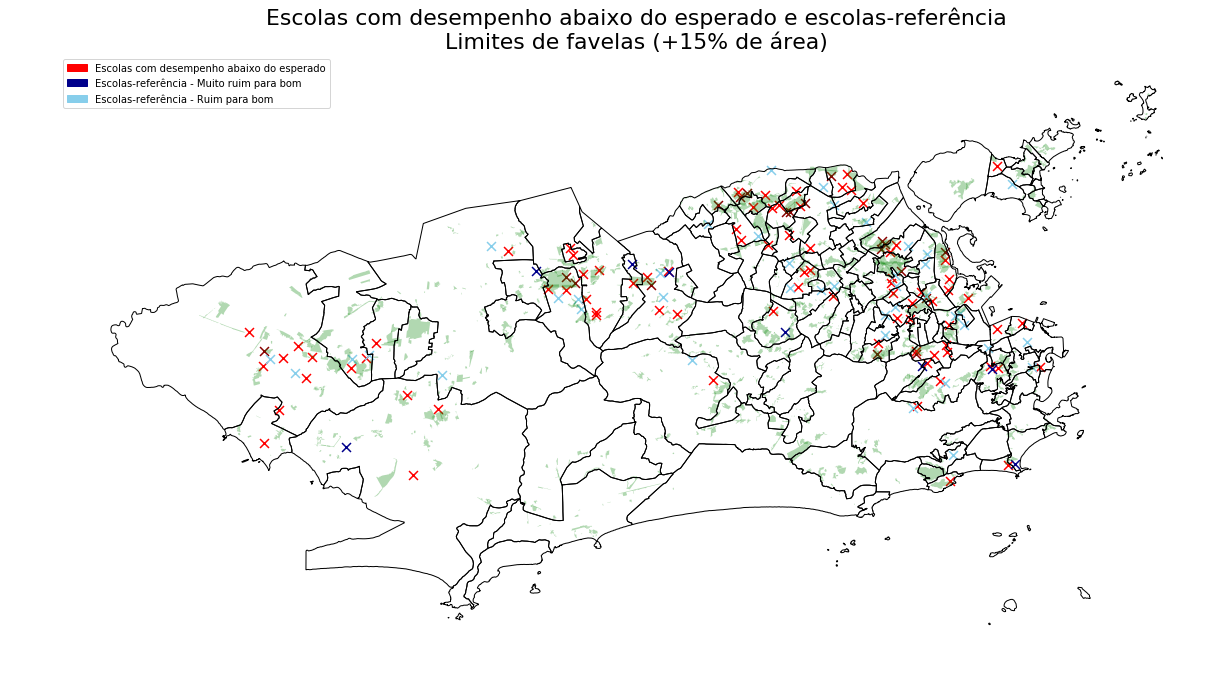

In [180]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, figsize=(22, 11))

risco.query("favela_bool == True").plot(ax=ax,color="darkred", marker="x", markersize=80)
risco.query("favela_bool == False").plot(ax=ax, color = "red", marker = "x", markersize=80)
ruim_pra_bom.plot(ax=ax, color = "skyblue", marker = "x", markersize=80)
pessimo_pra_bom.plot(ax=ax, color = "darkblue", marker = "x", markersize=80)
map_favelas_expandidas.plot(ax=ax, color = "green", alpha = 0.3)

map_geral_rio.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax) #Use your second dataframe

plt.axis('off')

plt.title("Escolas com desempenho abaixo do esperado e escolas-referência\nLimites de favelas (+15% de área)", fontsize = 22)

r = mpatches.Patch(color='red', label='Escolas com desempenho abaixo do esperado')
db = mpatches.Patch(color='darkblue', label='Escolas-referência - Muito ruim para bom')
sb = mpatches.Patch(color='skyblue', label='Escolas-referência - Ruim para bom')

plt.legend(handles=[r, db, sb], loc = "upper left")

plt.savefig("point_map_favelas_expandidas.png", dpi = 600)

# Verifica as diferenças de INSE entre escolas que ficam dentro e fora da favela

In [181]:
inse = pd.read_excel("INSE_2015.xlsx")
inse.rename(columns={"CO_ESCOLA" : "cod_inep"}, inplace=True)
inse.head()

,cod_inep,NOME_ESCOLA,CO_UF,NOME_UF,CO_MUNICIPIO,NOME_MUNICIPIO,ID_AREA,TP_DEPENDENCIA,TP_LOCALIZACAO,QTD_ALUNOS_INSE,INSE_VALOR_ABSOLUTO,INSE_CLASSIFICACAO
0,11000058,CENTRO DE ENSINO CLASSE A,11,Rondônia,1100205,1100205,1,4,1,130,64.17,Grupo 6
1,11000171,CENTRO EDUCACIONAL MOJUCA,11,Rondônia,1100205,1100205,1,4,1,17,54.96,Grupo 4
2,11000198,CENTRO EDUCACIONAL OBJETIVO,11,Rondônia,1100205,1100205,1,4,1,37,61.17,Grupo 5
3,11000201,EEEF PROF HERBERT DE ALENCAR,11,Rondônia,1100205,1100205,1,2,1,86,53.46,Grupo 4
4,11000244,COLEGIO DOM BOSCO,11,Rondônia,1100205,1100205,1,4,1,49,56.88,Grupo 5


In [182]:
referencias = ruim_pra_bom.append(pessimo_pra_bom)
referencias = pd.merge(referencias, inse[["cod_inep", "NOME_ESCOLA", "INSE_VALOR_ABSOLUTO", "INSE_CLASSIFICACAO"]], how = "left", on = "cod_inep")
risco = pd.merge(risco, inse[["cod_inep", "NOME_ESCOLA", "INSE_VALOR_ABSOLUTO", "INSE_CLASSIFICACAO"]], how="left", on="cod_inep")

In [183]:
risco["tipo"] = "Escolas com desempenho abaixo do esperado"
referencias["tipo"] = "Escolas-referência"

In [187]:
df = risco.append(referencias)

In [189]:
df.head()

,cod_inep,geometry,SMEDBOEs_5,favela_bool,NOME_ESCOLA,INSE_VALOR_ABSOLUTO,INSE_CLASSIFICACAO,tipo
0,33069301,POINT (677137.75970623 7472211.235278567),Escola Municipal Luiz Cesar SayÃ£o Garcez,False,0410023 ESCOLA MUNICIPAL LUIZ CESAR SAYAO GARCEZ,52.72,Grupo 4,Escolas com desempenho abaixo do esperado
1,33069450,POINT (680676.2907624769 7469102.951167688),Escola Municipal Teotonio Vilela,False,0430002 ESCOLA MUNICIPAL TEOTONIO VILELA,47.15,Grupo 3,Escolas com desempenho abaixo do esperado
2,33068771,POINT (680774.8086924865 7469886.242025971),CIEP Ministro Gustavo Capanema,False,0430201 CIEP MINISTRO GUSTAVO CAPANEMA,46.24,Grupo 3,Escolas com desempenho abaixo do esperado
3,33068747,POINT (680504.8789207698 7471678.75495597),CIEP HÃ©lio Smidt,True,0430206 CIEP HELIO SMIDT,46.46,Grupo 3,Escolas com desempenho abaixo do esperado
4,33068739,POINT (680529.4201014914 7471141.355483465),CIEP Elis Regina,False,0430502 CIEP ELIS REGINA,47.32,Grupo 3,Escolas com desempenho abaixo do esperado


In [197]:
df["favela_text"] = np.where(df["favela_bool"] == True, "Dentro de favela", "Fora de favela")

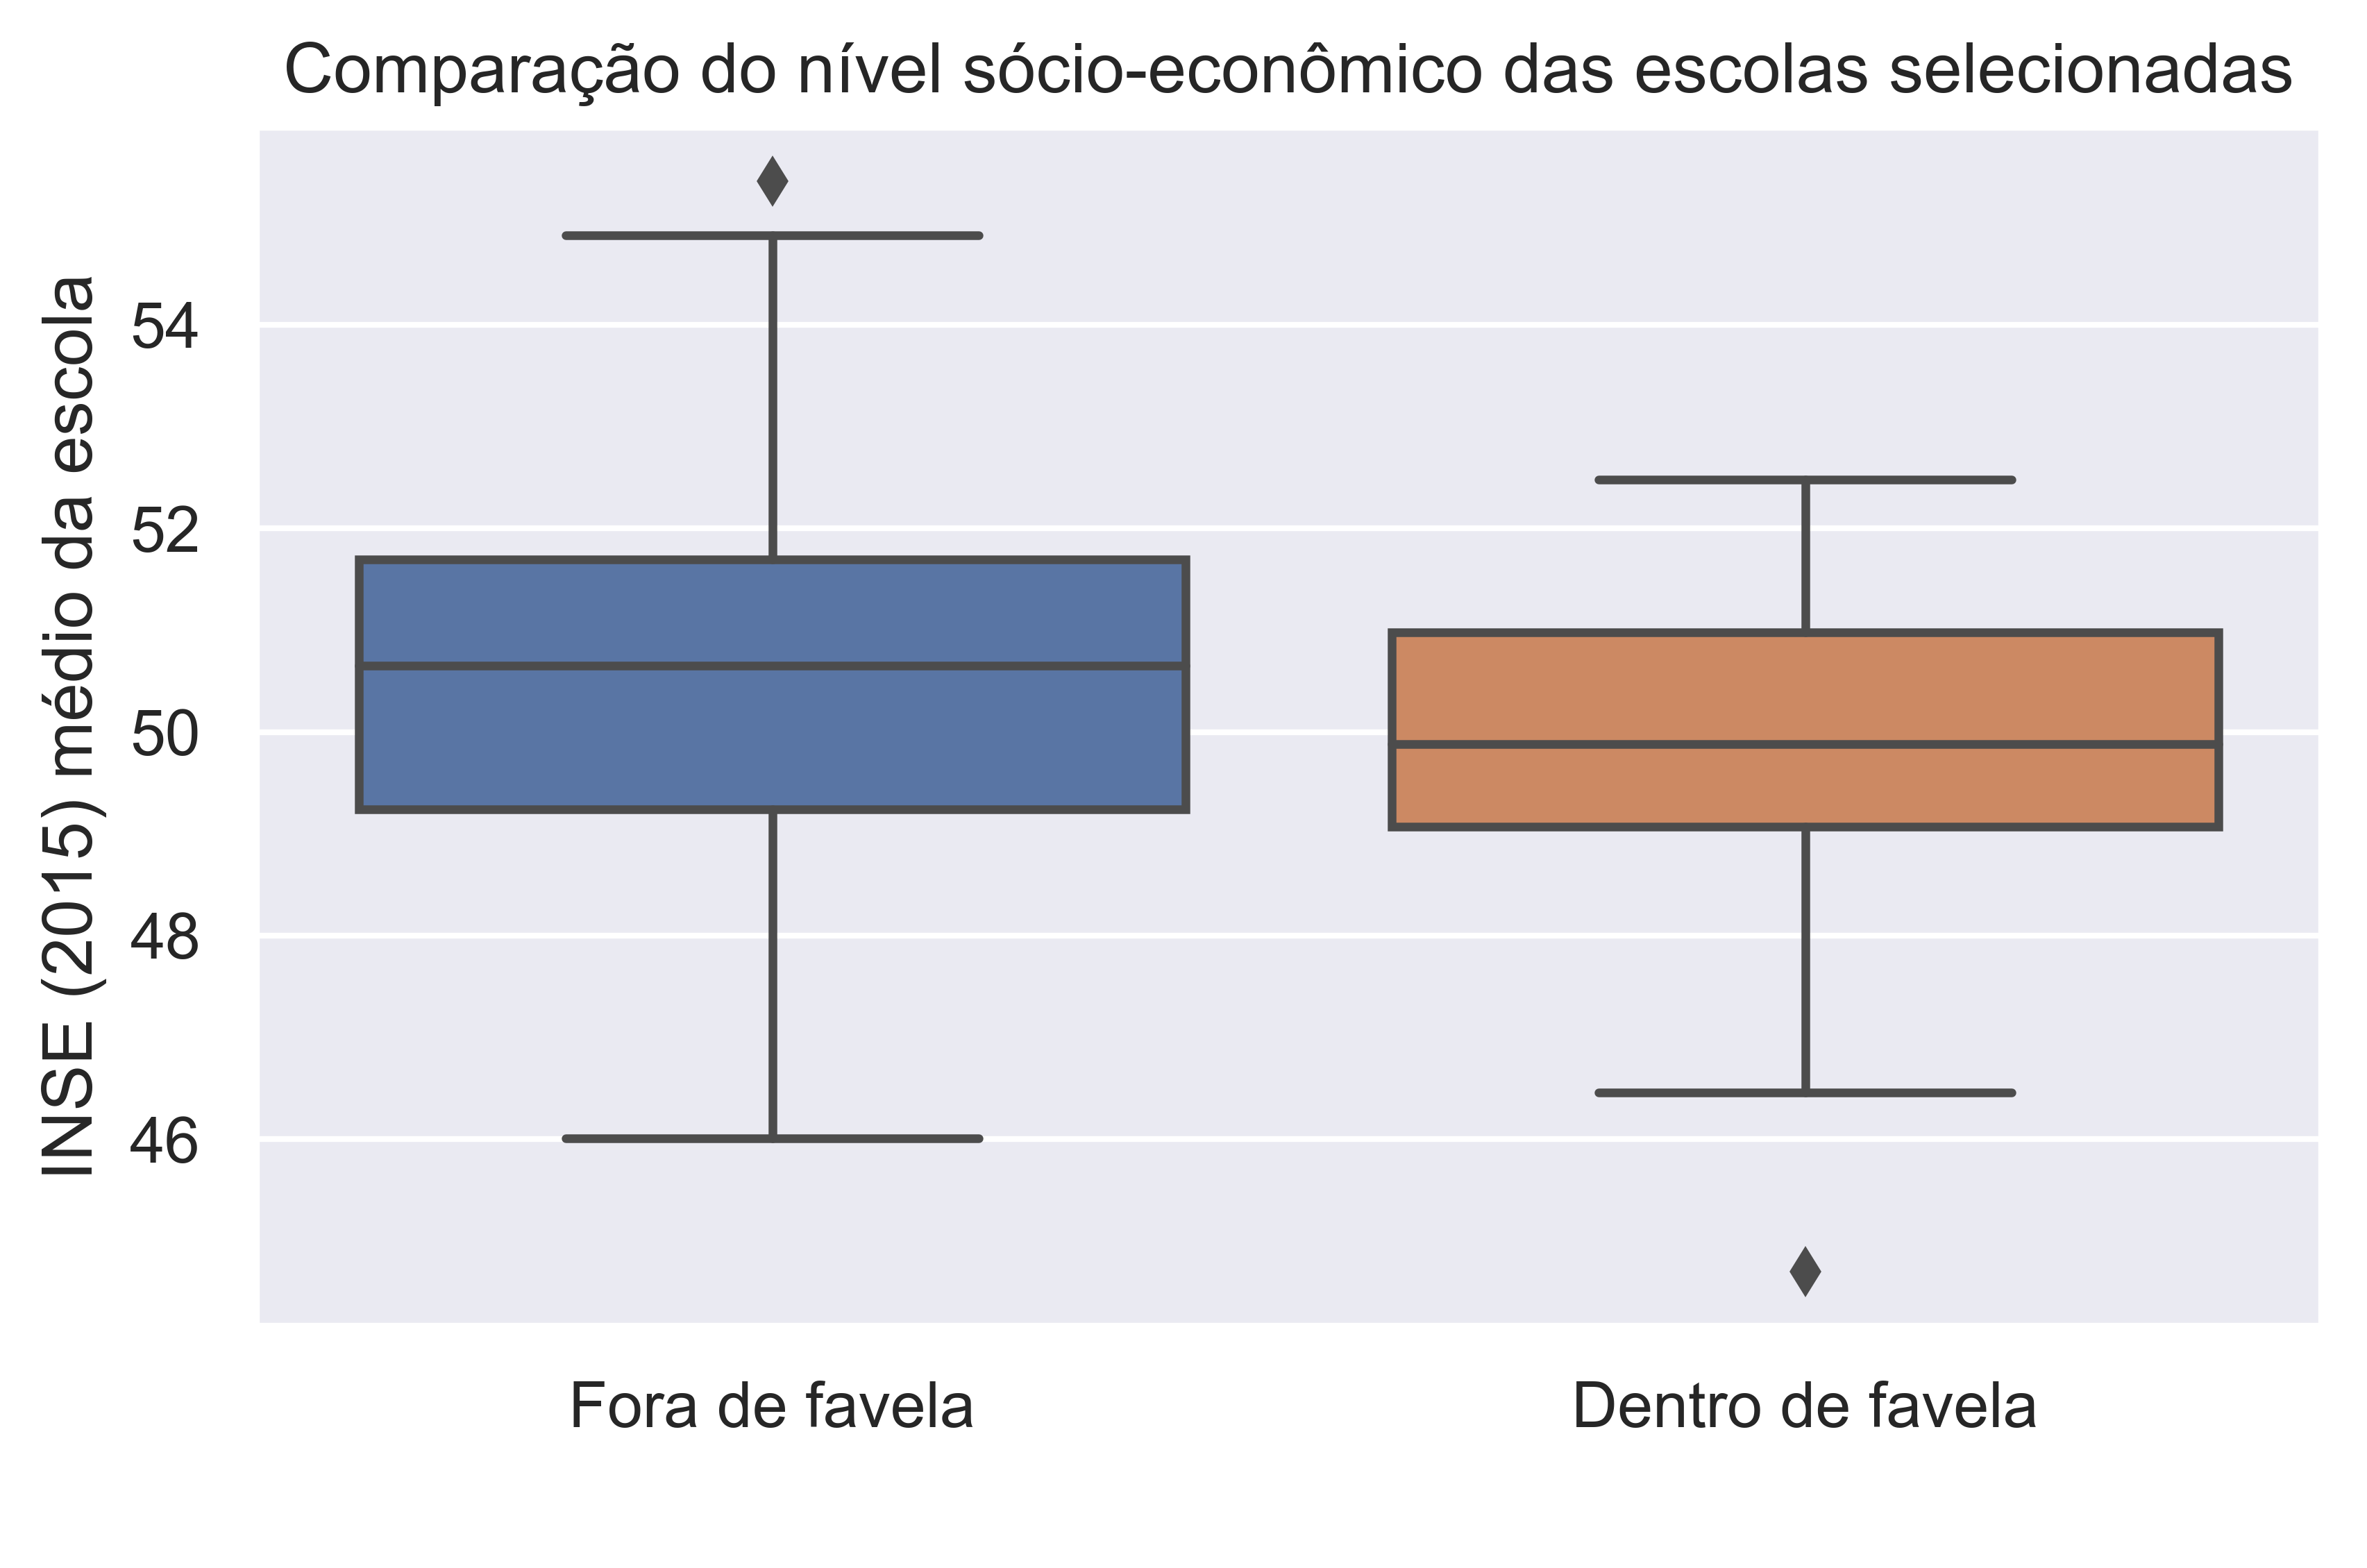

In [200]:
sen.sen_boxplot(x = "favela_text", y = "INSE_VALOR_ABSOLUTO", y_label = "INSE (2015) médio da escola", x_label = " ",
                plot_title = "Comparação do nível sócio-econômico das escolas selecionadas",
                data = df, output_path = "inse_v_favela.png")

In [204]:
from scipy.stats import ttest_ind as ttest
ttest(df.dropna(subset = ["INSE_VALOR_ABSOLUTO"]).query("favela_bool == True")["INSE_VALOR_ABSOLUTO"], df.dropna(subset = ["INSE_VALOR_ABSOLUTO"]).query("favela_bool == False")["INSE_VALOR_ABSOLUTO"])

Ttest_indResult(statistic=-1.237462388455761, pvalue=0.21788846558409883)

# Testa o efeito dos limites de favela sobre o IDEB

In [201]:
#pega a nota do IDEB pra servir de DV
ideb = pd.read_csv("./pr-educacao/data/output/ideb_merged_kepler.csv")
ideb["ano_true"] = ideb["ano"].apply(lambda x: int(x[0:4]))
ideb = ideb.query("ano_true == 2017").copy()
nota_ideb = ideb[["cod_inep", "ideb"]]

df = pd.merge(df, nota_ideb, how = "left", on = "cod_inep")

In [206]:
df["favela_bin"] = df["favela_bool"].astype("int")

In [209]:
df.dtypes

cod_inep                 int64
geometry                object
SMEDBOEs_5              object
favela_bool               bool
NOME_ESCOLA             object
INSE_VALOR_ABSOLUTO    float64
INSE_CLASSIFICACAO      object
tipo                    object
favela_text             object
ideb                   float64
favela_bin               int64
dtype: object

In [219]:
from statsmodels.regression.linear_model import OLS as ols_py
from statsmodels.tools.tools import add_constant

df_puro = df.dropna(subset = ["INSE_VALOR_ABSOLUTO", "favela_bin", "ideb"])

ivs_multi = add_constant(df_puro[["INSE_VALOR_ABSOLUTO", "favela_bin"]])
dv = df_puro[["ideb"]]

modelo_multi = ols_py(dv, ivs_multi).fit()

print(modelo_multi.summary())

/home/almeida2808/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                   ideb   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     22.10
Date:                ter, 11 jun 2019   Prob (F-statistic):           4.12e-09
Time:                        18:05:31   Log-Likelihood:                -142.00
No. Observations:                 149   AIC:                             290.0
Df Residuals:                     146   BIC:                             299.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.9961    

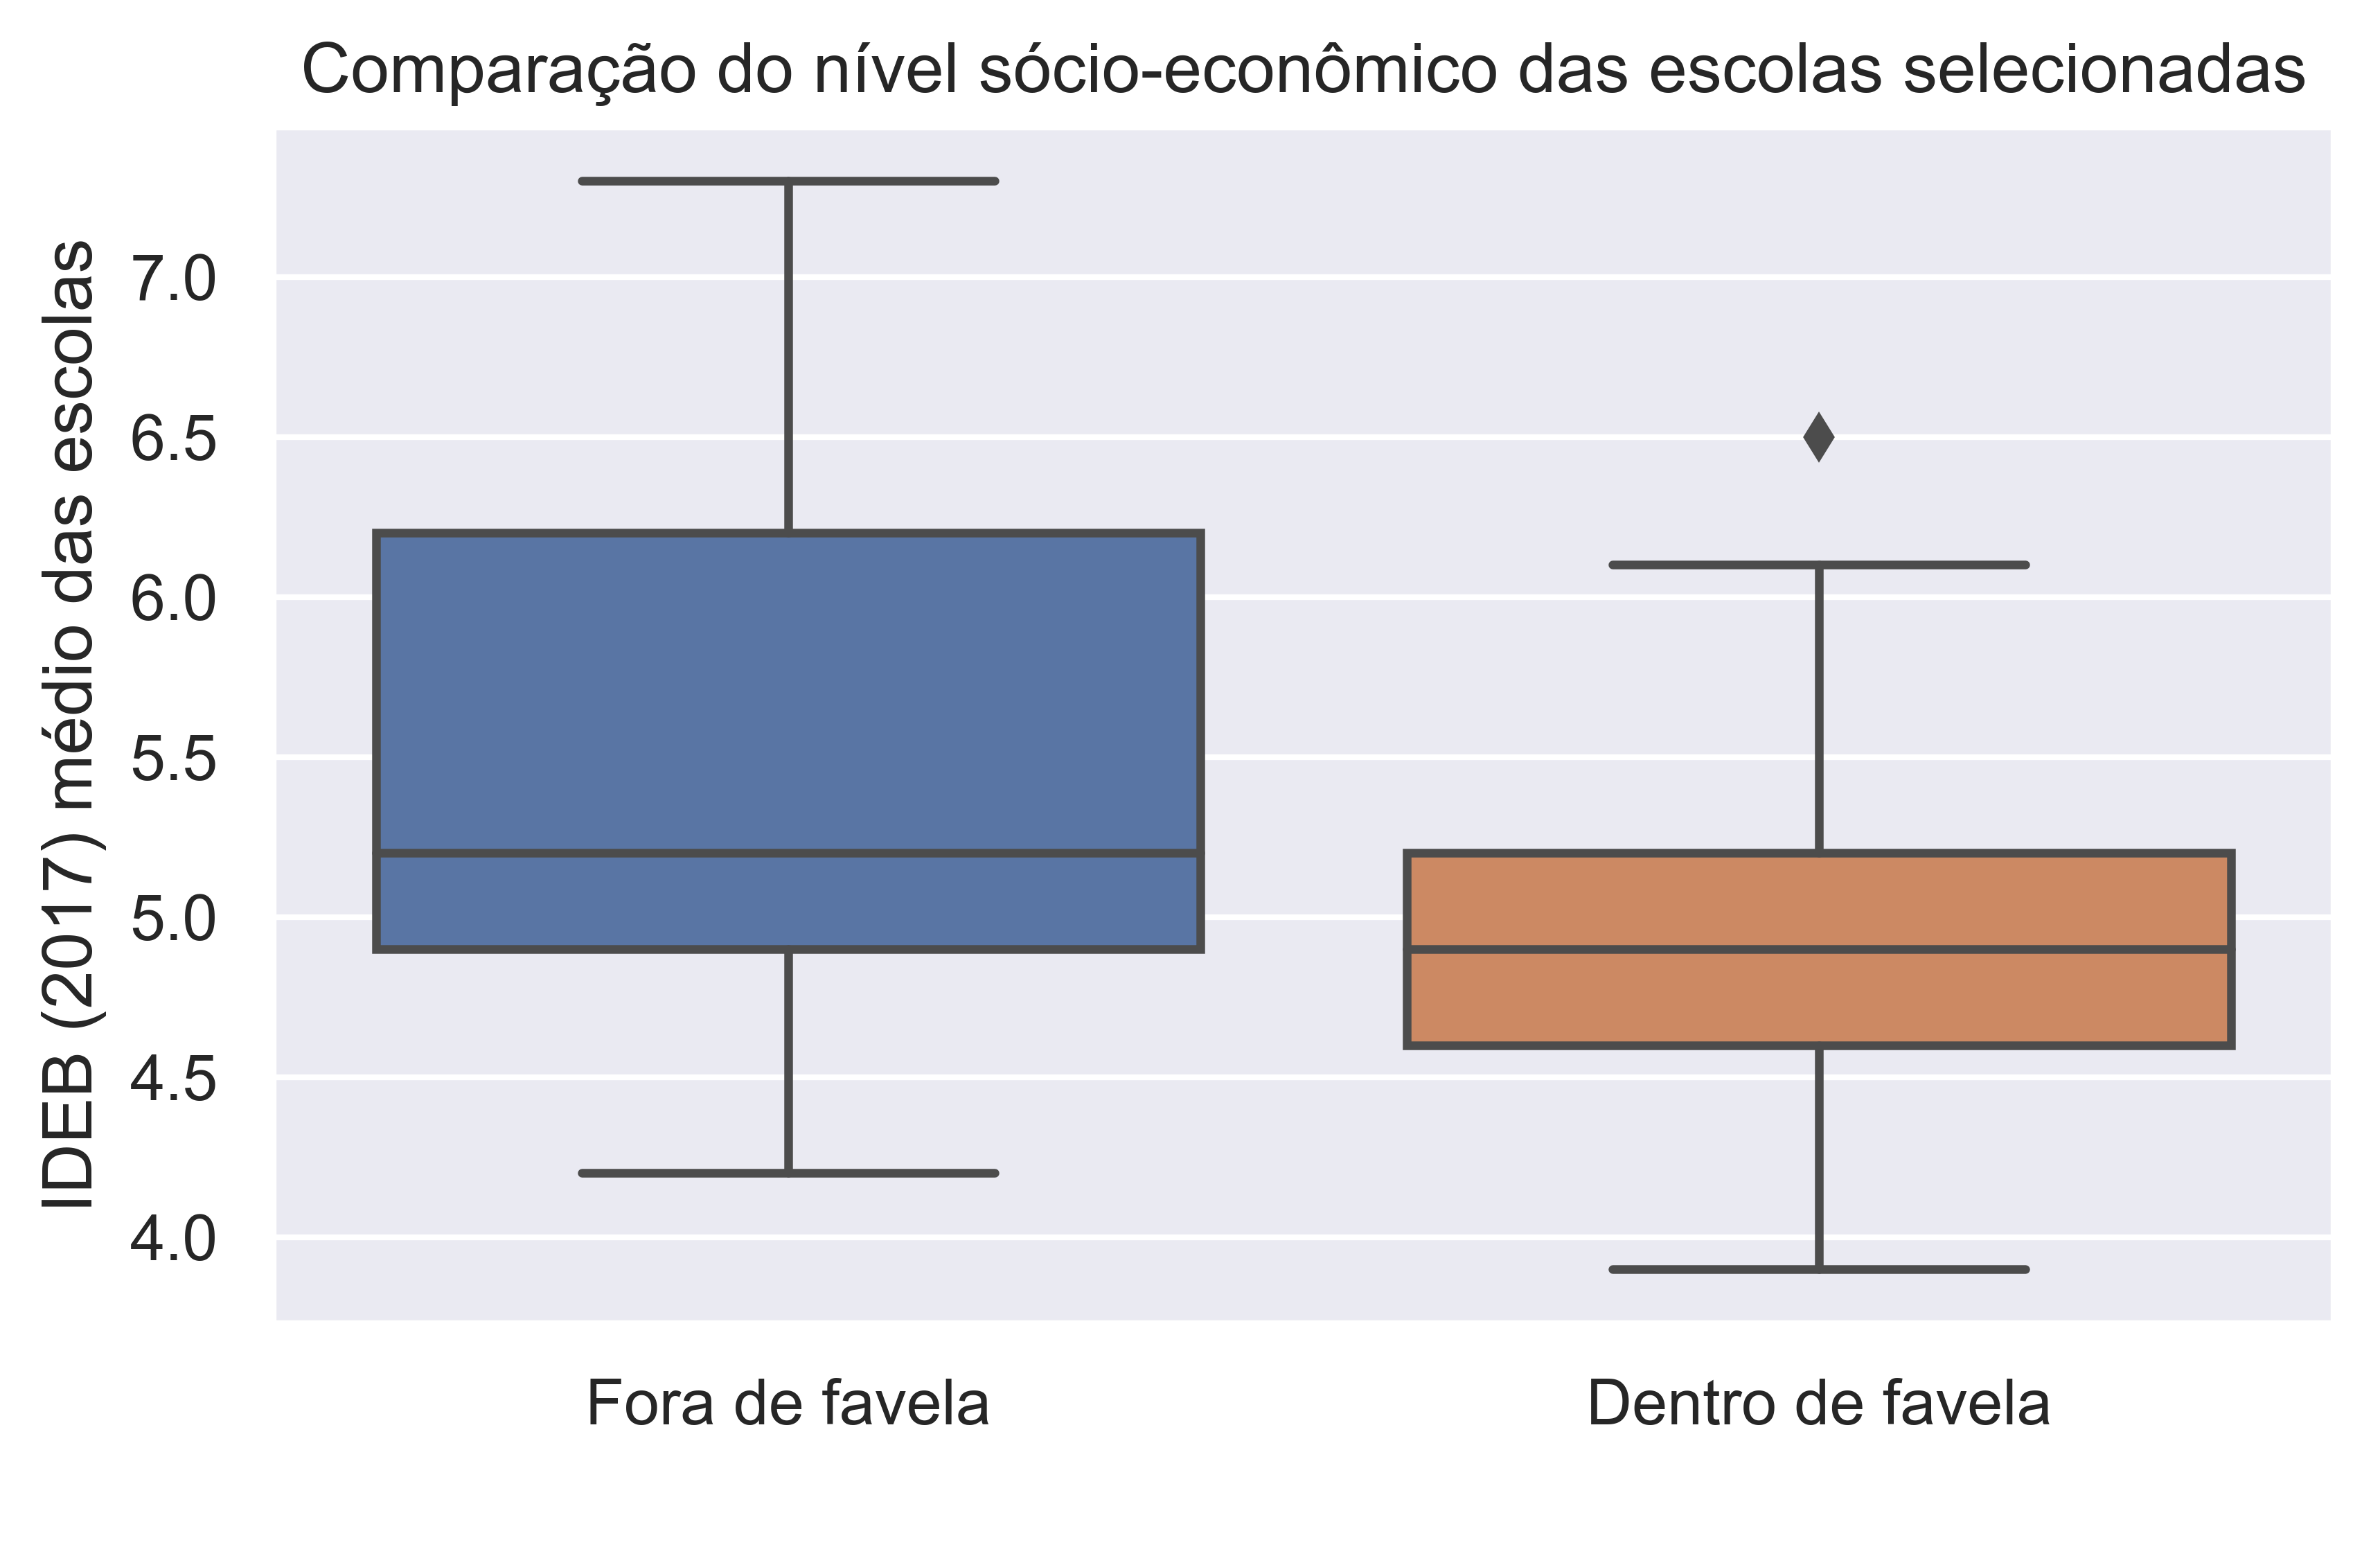

In [220]:
sen.sen_boxplot(x = "favela_text", y = "ideb", y_label = "IDEB (2017) médio das escolas", x_label = " ",
                plot_title = "Comparação do nível sócio-econômico das escolas selecionadas",
                data = df, output_path = "ideb_v_favela.png")

# Olha apenas para os pares fora de favela

In [221]:
pairs = pd.read_csv("sponsors_mais_proximos.csv")

In [223]:
#pega as escolas de risco na favela para tirar dos pares possíveis
risco_favela = risco.query("favela_bool == True")["cod_inep"]

In [227]:
pairs_asfalto = pairs.query("cod_inep_risco not in @risco_favela")
pairs_asfalto.shape

(82, 10)